# Model 1

First I'm attempting to model Track Number $Tn$ as a function of features $f$ and weights $\beta$,

\begin{equation}
Tn(\beta, f) = \beta_0 + \beta_1 f_1 + ... + \beta_p f_p + \epsilon
\end{equation}

where $p$ is the number of features from our dataset. The intuition behind this model is that there could be a tendency of increase/decrease in track number related to increases/decreases in $f$. 

For instance, based on [these graphs](https://pasoneto.github.io/doc_suomi/descriptives.slides.html#/3), I would hypothesize that valence, energy and loudness get lower towards the end of the album. If this is true, $\beta$ should be negative (as feature magnitude increases, track number decreases).

I chose to explain $Tn$ as a function of $f$ instead of trying to explain $f$ as a function of $Tn$, because if I did it the second way, I would have to fit one model to each one of our dependent variable ($f$), or compute some sort of composite score of features (which is a possibility for the future).

In [3]:
source("/home/pasoneto/Documents/github/doc_suomi/code/utils.R")
setwd("/home/pasoneto/Documents/github/doc_suomi/data")

In [4]:
dt = fread("novo.csv")
dt %<>% group_by(album_id) %>% mutate(album_length = NROW(track_number)) %>%
         dplyr::filter(album_length %in% c(6:15)) %>%
         dplyr::select(album_id, track_number, valence, energy, loudness, tempo) %>%
         mutate(valence  = z(valence),  energy   = z(energy),
                loudness = z(loudness), tempo    = z(tempo),
                position = segment2(track_number)) %>% ungroup()

## Result - Model 1

In [5]:
summary(lm(track_number~valence*energy*loudness*tempo, data = dt))


Call:
lm(formula = track_number ~ valence * energy * loudness * tempo, 
    data = dt)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.7229 -3.1608 -0.2466  2.7683  9.2236 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    6.4356498  0.0201779 318.945  < 2e-16 ***
valence                       -0.1115567  0.0218890  -5.096 3.47e-07 ***
energy                        -0.1454631  0.0253258  -5.744 9.33e-09 ***
loudness                      -0.1744116  0.0251046  -6.947 3.77e-12 ***
tempo                         -0.0146344  0.0211298  -0.693 0.488568    
valence:energy                 0.0902890  0.0238297   3.789 0.000152 ***
valence:loudness              -0.0636685  0.0252488  -2.522 0.011684 *  
energy:loudness                0.0710992  0.0183980   3.864 0.000111 ***
valence:tempo                 -0.0378966  0.0225093  -1.684 0.092266 .  
energy:tempo                   0.0423689  0.0254210   1.667 0.095584 .  


## Discussion - Model 1

Results show an overall significant model, with significant $\beta$s for valence, energy and tempo. More importantly, $\beta$ for these variables was negativelly correlated with $Tn$, which means that: as valence, energy and loudness increase, $Tn$ decreases. In other words: albums tend to begin with more energy, loudness and higher valence.

### Problems

$R$ square shows a small effect size, explaining around $1\%$ of the variance. Also, here I'm predicting continuous values for an rank-ordered variable ($Tn$). Model 3 presents an alternative to the second problem.

# Model 3

Here I'm using a multinomial logistic regression to predict whether a track is in position 1, 2, 3 or 4. Predictor varibles are normalized and features are averaged within positions. 

I fit the model to 75% of the data, and evaluated its performance on the remaining 25%. Data was perfectly balanced with 25% of trials on each category.

## Evaluation strategies

1) Accuracy - Performance was evaluated using a cross-validation strategy: I fitted the model on 10 different training sets, and evaluated it on 10 different test sets.

2) Sanity check - In order to evaluate if our results could be due to something different from track ordering factors, I repeated the same model on a randomized version of the original dataset. First I shuffled track orders within each album, and then I computed the average features within each album position, for each album. Should our model have any value, fitting it in a randomized dataset would decrease its accuracy. Results are also cross validated.

## Results 3
### Accuracy

In [4]:
dt = fread("novo.csv")
dt %<>%
    group_by(album_id) %>% mutate(album_length = NROW(track_number)) %>%
    dplyr::filter(album_length %in% c(6:15)) %>% 
    dplyr::select(album_id, track_number, valence, energy, loudness, tempo) %>%
    mutate(valence  = z(valence),  energy   = z(energy), loudness = z(loudness), tempo    = z(tempo),
        position = segment2(track_number)) %>%
    group_by(album_id, position)%>%
    summarise(valence = mean(valence), energy = mean(energy),
              loudness = mean(loudness), tempo = mean(tempo)) %>% ungroup()
dt$position <- relevel(as.factor(dt$position), ref = "1st")

result = cros(multinom, 1)

`summarise()` regrouping output by 'album_id' (override with `.groups` argument)



# weights:  68 (48 variable)
initial  value 15687.306990 
iter  10 value 15565.240515
iter  20 value 15478.352779
iter  30 value 15434.412867
iter  40 value 15420.432986
iter  50 value 15416.906185
final  value 15416.861410 
converged


## Model summary

Coefficients

In [ ]:
summary(result$model)$coefficients

p-values:

In [12]:
#p-valuses
z <- summary(result$model)$coefficients/summary(model)$standard.errors; p <- (1 - pnorm(abs(z), 0, 1))*2; 
p

,(Intercept),valence,energy,loudness,tempo,valence:energy,valence:loudness,energy:loudness,valence:tempo,energy:tempo,loudness:tempo,valence:energy:loudness,valence:energy:tempo,valence:loudness:tempo,energy:loudness:tempo,valence:energy:loudness:tempo
2nd,0.08212057,7.521196e-01,4.876100e-13,3.262765e-01,0.2021708,0.2916568,0.0071632524,0.9867287,0.05806984,0.9929431,0.4134239,0.2692720,0.87999435,0.1581306,0.2482836,0.478788553
3d,0.01128788,7.702824e-01,8.323964e-11,1.808157e-04,0.2194518,0.1400292,0.0002349035,0.2867594,0.02470089,0.6328526,0.1461950,0.7549967,0.39053219,0.3189992,0.6891472,0.406761347
4th,0.25250899,6.120345e-06,2.664535e-15,2.591243e-09,0.4581178,0.4313700,0.4757045102,0.3223784,0.37040883,0.6655896,0.8248642,0.2930966,0.05142103,0.1193824,0.8277664,0.005223846


## Probability graphs by position

Warning message in melt(., measure.vars = c("valence", "energy", "loudness", "tempo")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error.”
`geom_smooth()` using formula 'y ~ x'

Warning message in melt(., measure.vars = c("valence", "energy", "loudness", "tempo")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In t

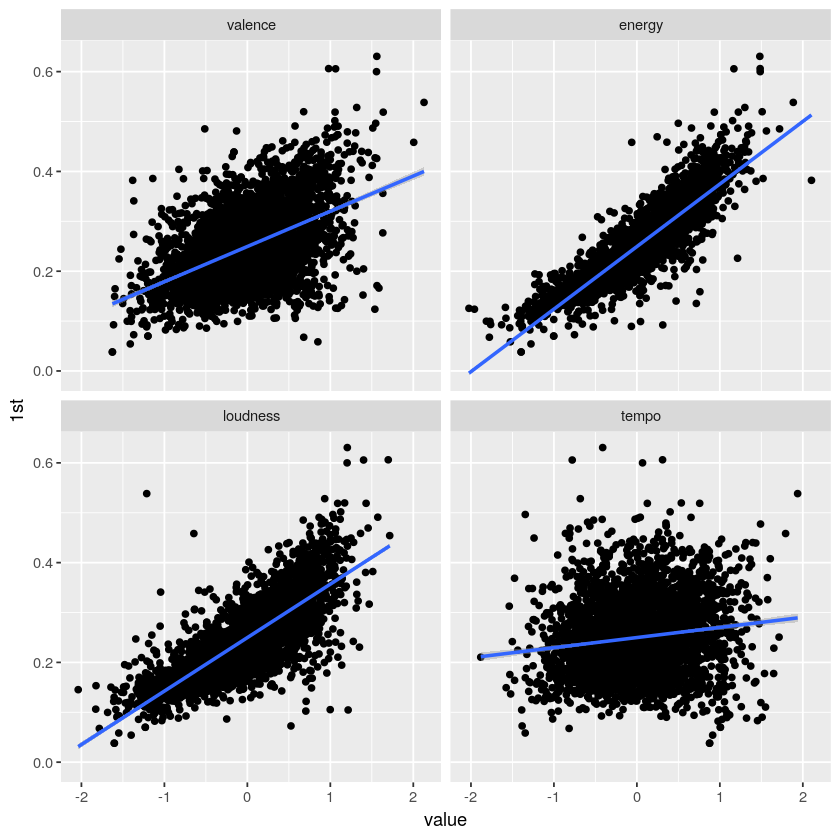

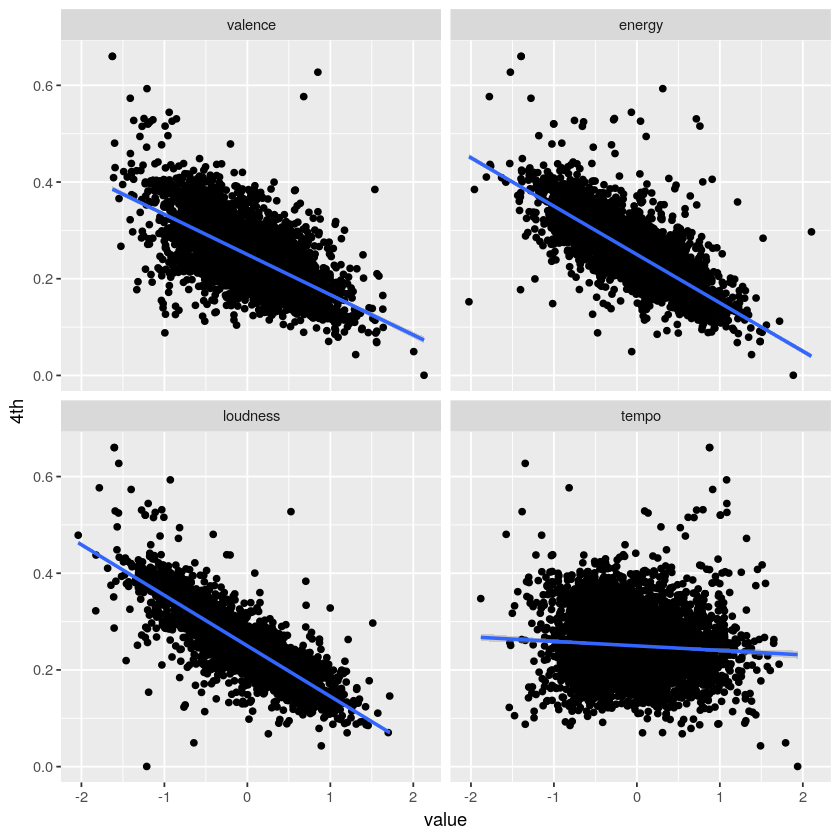

In [7]:
result$probs %>%
     dplyr::select("valence", "energy", "loudness", "tempo", "1st", "2nd", "3d", "4th", "position") %>%
     melt(measure.vars = c("valence", "energy", "loudness", "tempo")) %>%
     ggplot(aes(x = value, y = `1st`))+
         facet_wrap(~variable)+
         geom_point() + geom_smooth(method = "lm")

result$probs %>%
     dplyr::select("valence", "energy", "loudness", "tempo", "1st", "2nd", "3d", "4th", "position") %>%
     melt(measure.vars = c("valence", "energy", "loudness", "tempo")) %>%
     ggplot(aes(x = value, y = `4th`))+
         facet_wrap(~variable)+
         geom_point() +
         geom_smooth(method = "lm")

## Discussion - Model 3

With an overall accuracy of 31%, multinomial logistic regression barely surpasses chance level (25%).

However, the $\textbf{error}$ was not well distributed across categories, and there was a higher accuracy for tracks in the $\textbf{1st and 4th positions}$ of the album. 

Sensitivity (proportion of true positives) was higher for positions 1 and 4. Specificity (proportion of true positives), on the other hand, was lower for these categories.

With the sanity check (shuffled dataset), we acheived an accuracy of 0.247 throughout all categories, and a uniform distribution throughout the confusion matrix.

# Model 4

Here I'm attempting to predict the same thing as models 2 and 3, but with a random forest model. Evaluation was also done in terms of accuracy and sanity check.

In [ ]:
result = cros(randomForest, 10)

## Results 4
### Accuracy

In [ ]:
result$conf_matrix

## Probability graphs

In [ ]:
result$probs %>%
     dplyr::select("valence", "energy", "loudness", "tempo", "1st", "2nd", "3d", "4th", "position") %>%
     melt(measure.vars = c("valence", "energy", "loudness", "tempo")) %>%
     ggplot(aes(x = value, y = `1st`))+
         facet_wrap(~variable)+
         geom_point() + geom_smooth(method = "lm")

result$probs %>%
     dplyr::select("valence", "energy", "loudness", "tempo", "1st", "2nd", "3d", "4th", "position") %>%
     melt(measure.vars = c("valence", "energy", "loudness", "tempo")) %>%
     ggplot(aes(x = value, y = `4th`))+
         facet_wrap(~variable)+
         geom_point() +
         geom_smooth(method = "lm")

In [ ]:
############ Sanity check ############
dt = fread("novo.csv")

dt %<>%
    group_by(album_id) %>% mutate(album_length = NROW(track_number)) %>%
    filter(album_length %in% c(6:15))                                %>% 
    select(album_id, track_number, valence, energy, loudness, tempo) %>%
    mutate(valence = z(sample(valence, NROW(valence), replace = FALSE)), z(sample(energy, NROW(energy), replace = FALSE)), 
           loudness = z(sample(loudness, NROW(loudness), replace = FALSE)), z(sample(tempo, NROW(tempo), replace = FALSE)), 
           position = segment2(track_number)) %>% ungroup()          %>%
    group_by(position, album_id)  %>%   
    summarise(valence = mean(valence), energy = mean(energy),
              loudness = mean(loudness), tempo = mean(tempo))        %>%
    ungroup() %>% arrange(album_id)

cros(randomForest, 10)

### Sanity check

In [ ]:
evaluator = tibble(predicted = factor(predicted), true = factor(true))
confusionMatrix(data = evaluator$predicted, reference = evaluator$true)

noquote("Number of observations per category: ")
table(evaluator$true)

## Discussion - Model 4

Accuracy increases to 38% on 10 runs of crossvalidation. Correct predictions are still concentrated on the 1st and 4th sections (balenced accuracy is promosing for these categories).

Again, shuffled album orders dropped the accuracy to baseline.

# Overall discussion

It seems like models 3 and 4 are more accurate for sections 1 and 4.

These results made me think back about the [dissimilarity matrix](https://pasoneto.github.io/doc_suomi/descriptives.slides.html#/5/0/0), which shows that Track 1 has a generally higher dissimilarity rating. 

Perhaps there is a higher level of information within the first and last sections of the album. Even though I didn't find any study about this "opening/closing effect" , it seems like there is some mentions to it in blog posts that teach you how to sequence album and playlist tracks: 

## Anecdotes

- 'Lead with an impactful track. It’s vital for inviting your listeners in for the long haul. The lead track is your album’s first impression, so make it count.' [Blog post](https://blog.landr.com/album-sequencing/)

- 'Finish strong - The last track on the album should stay with the listener – if you’ve front loaded tracks 1 to 3 then save the next “best” to end with.' [Blog post](https://www.quora.com/How-do-recording-artists-decide-on-the-order-of-the-songs-on-their-CDs)

- 'you need to let listeners know straightaway why you are worth listening to. Don’t start with a skit. Don’t start with that cool, arty track you love but no one else seems to because you want to “set the mood.” Hit ‘em with your best shot, right off the bat.' [Blog post](https://blog.discmakers.com/2020/01/how-to-sequence-an-album/)

- 'Start with a hook. Whatever your theme, genre, or taste, one thing about playlists is universal: it's got to start with a great song. Lead off with a song that'll hook everyone who'll listen, or will kick off your personal favorites playlist with a bang.' [Blog post](https://www.wikihow.com/Make-an-Awesome-Music-Playlist)

- 'Skip to the end of each song, so that you get the last 15 to 20 seconds of it and figure out how that transition sounds. Even if you don’t know what the tempo is precisely, you can still tell the difference between an upbeat song and a slow song' [Blog post](https://live365.com/blog/10-tips-for-creating-perfect-radio-playlists/)